In [1]:
# Import needs libraries
from models.created_classes.Attention_U_net.Attention_UnetModel import *
from models.created_classes.U_net.UNetModel import *

import os
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchmetrics

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
import requests

# Setup agnostic-code cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [44]:
torch.cuda.empty_cache()

In [2]:
!nvidia-smi

Tue May 23 17:27:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650         Off| 00000000:01:00.0  On |                  N/A |
| N/A   38C    P8                2W /  N/A|     57MiB /  4096MiB |     32%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1. Download CityScapes dataset from `torchvision.datasets`

In [3]:
data_path = '/media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/Datasets/CityScapes'

In [4]:
train_data = datasets.Cityscapes(root=data_path,
                                 split="train",
                                 mode="fine",
                                 target_type="semantic",
                                 target_transform=None)
train_data

Dataset Cityscapes
    Number of datapoints: 2975
    Root location: /media/evgeny/6610D40610D3DB5F/Download_Softwares/PyCharm/Projects/2D_SemSeg_VKR/Datasets/CityScapes
    Split: train
    Mode: gtFine
    Type: ['semantic']

In [5]:
train_data[0]

(<PIL.Image.Image image mode=RGB size=2048x1024>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=2048x1024>)

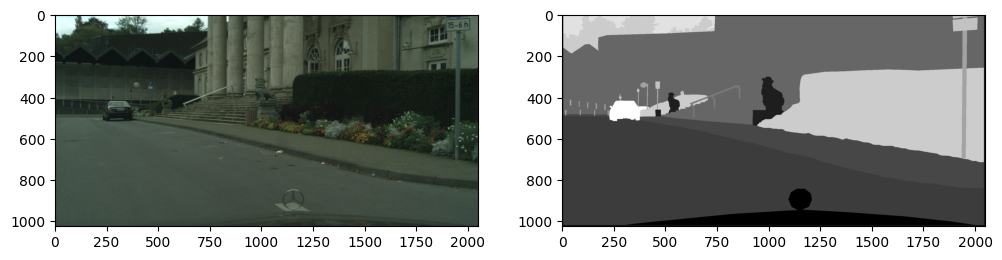

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
ax[0].imshow(train_data[0][0])
ax[1].imshow(train_data[0][1], cmap='gray')

## Some utils functions

In [7]:
ignore_index = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = [ "unlabled", "road", "sidewalk", "building", "wall", "fence", "pole", "traffic_light", 
               "traffic_sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", 
               "train", "motorcycle", "bicycle"]

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)
print(f"len(n_classes): {n_classes}\n")
print(class_map)

len(n_classes): 20

{255: 0, 7: 1, 8: 2, 11: 3, 12: 4, 13: 5, 17: 6, 19: 7, 20: 8, 21: 9, 22: 10, 23: 11, 24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 31: 17, 32: 18, 33: 19}


In [8]:
colors = [[0, 0, 0],
          [128, 64, 128],
          [244, 35, 232],
          [70, 70, 70],
          [102, 102, 156],
          [190, 153, 153],
          [153, 153, 153],
          [250, 170, 30],
          [220, 220, 0],
          [107, 142, 35],
          [152, 251, 152],
          [0, 130, 180],
          [220, 20, 60],
          [255, 0, 0],
          [0, 0, 142],
          [0, 0, 70],
          [0, 60, 100],
          [0, 80, 100],
          [0, 0, 230],
          [119, 11, 32],
        ]

label_colors = dict(zip(range(n_classes), colors))
label_colors

{0: [0, 0, 0],
 1: [128, 64, 128],
 2: [244, 35, 232],
 3: [70, 70, 70],
 4: [102, 102, 156],
 5: [190, 153, 153],
 6: [153, 153, 153],
 7: [250, 170, 30],
 8: [220, 220, 0],
 9: [107, 142, 35],
 10: [152, 251, 152],
 11: [0, 130, 180],
 12: [220, 20, 60],
 13: [255, 0, 0],
 14: [0, 0, 142],
 15: [0, 0, 70],
 16: [0, 60, 100],
 17: [0, 80, 100],
 18: [0, 0, 230],
 19: [119, 11, 32]}

In [9]:
def encode_segmap(mask):
    """
    Переназначаем все нежелательные классы на ignore_index (255)
    а Желательные классы переопределяем на новые значения индексов
    """
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    # Преобразуем серое изображение в цветное RGB
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    
    for i in range(0, n_classes):
        r[temp == i] = label_colors[i][0]
        g[temp == i] = label_colors[i][1]
        b[temp == i] = label_colors[i][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [10]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from torchvision.datasets import Cityscapes

class MyClassCityscapes(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise, target is a json object if target_type="polygon", else the image segmentation.
        """

        image = Image.open(self.images[index]).convert("RGB")

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == "polygon":
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed = transform_A(image=np.array(image), mask=np.array(target))
            
        return transformed['image'], transformed['mask']

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_A = A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [12]:
train_data = MyClassCityscapes(root=data_path,
                                 split="train",
                                 mode="fine",
                                 target_type="semantic",
                                 transforms=transform_A,
                                 target_transform=None)

val_data = MyClassCityscapes(root=data_path,
                                 split="val",
                                 mode="fine",
                                 target_type="semantic",
                                 transforms=transform_A,
                                 target_transform=None)

test_data = MyClassCityscapes(root=data_path,
                                 split="test",
                                 mode="fine",
                                 target_type="semantic",
                                 transforms=transform_A,
                                 target_transform=None)

img, seg = train_data[10]
print(img.shape, seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


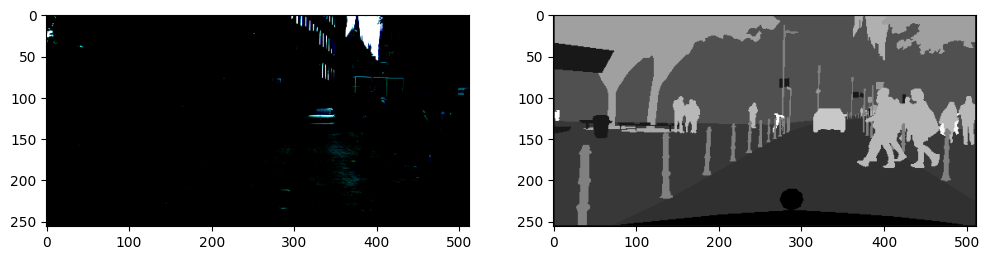

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(seg, cmap='gray')

In [14]:
# class labels after label correction
result = encode_segmap(seg.clone())
print(f"result shape: {result.shape}")
print(f"torch unique (result) : {torch.unique(result)}")
print(f"length: {len(torch.unique(result))}")

result shape: torch.Size([256, 512])
torch unique (result) : tensor([ 0,  1,  2,  3,  6,  8,  9, 10, 11, 12, 14, 18, 19], dtype=torch.uint8)
length: 13


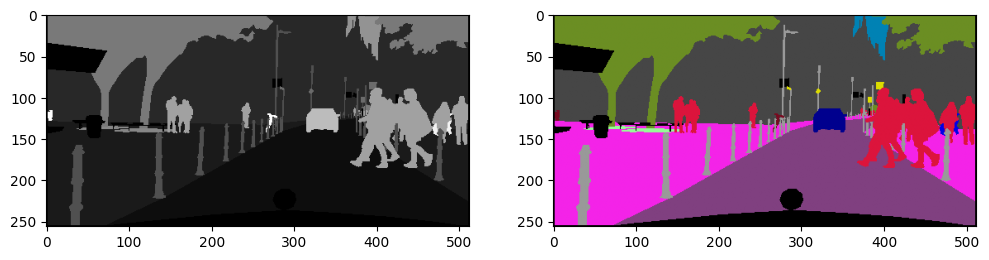

In [15]:
# let's add color in sem seg
result1 = decode_segmap(result.clone())

fig, ax = plt.subplots(ncols=2, figsize=(12,8))
ax[0].imshow(result, cmap='gray')
ax[1].imshow(result1)

## DataLoader

In [16]:
BATCH_SIZE = 1

In [17]:
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f55a8519730>,
 <torch.utils.data.dataloader.DataLoader at 0x7f55a85190a0>)

In [18]:
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of val_dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

Length of train_dataloader: 2975 batches of 1...
Length of val_dataloader: 500 batches of 1...
Length of test_dataloader: 1525 batches of 1...


In [29]:
train_step_vizualise_loss = len(train_dataloader)//6
val_step_vizualise_loss = len(val_dataloader)//5
test_step_vizualise_loss = len(test_dataloader)//5

print(f"test_step_vizualise_loss: {train_step_vizualise_loss}")
print(f"val_step_vizualise_loss: {val_step_vizualise_loss}")
print(f"test_step_vizualise_loss: {test_step_vizualise_loss}")

test_step_vizualise_loss: 495
val_step_vizualise_loss: 100
test_step_vizualise_loss: 305


In [19]:
batch, label = next(iter(train_dataloader))
batch.shape, label.shape

(torch.Size([1, 3, 256, 512]), torch.Size([1, 256, 512]))

# 2. Create Models

## Classic U-Net

In [20]:
UnetModel = UNetModel(input_channels=3,
                        output_classes=n_classes,
                        up_sample_mode='bilinear',
                        up_sample_align_corner=False,
                        padding=1,
                        stride=1,
                        kernel=3,
                        number_conv_layers=2,
                        ).to(device)
UnetModel

UNetModel(
  (input_layer): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_block_1): Down(
    (maxpool_conv_block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

## Attention U-Net

In [36]:
AttUnetModel = AttentionUnetModel(in_channels=3,
                        out_channels=n_classes,
                        mode='bilinear',
                        align_corner=False,
                        padding=1,
                        stride=1,
                        kernel=3,
                        numberConvLayers=2,
                        ).to(device)
AttUnetModel

AttentionUnetModel(
  (encoder_layer_1): Encoder_block(
    (conv): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_layer_2): Encoder_block(
    (conv): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(

## SegFormer

In [37]:
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b4-finetuned-cityscapes-1024-1024")
SegModel = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-cityscapes-1024-1024")
SegModel.to(device)
SegModel

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/evgeny/PycharmProjects/2D_SemSeg_VKR/venv/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## Loss function and optimizer

In [21]:
unet_optimizer = torch.optim.SGD(params=UnetModel.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00004)
# att_unet_optimizer = torch.optim.SGD(params=AttUnetModel.parameters(), lr=0.05, momentum=0.9, weight_decay=0.00004)
# seg_optimizer = torch.optim.AdamW(params=SegModel.parameters(), lr=0.00006, weight_decay=0.01)

loss_fn = nn.CrossEntropyLoss()

# 3. Train Loop

In [30]:
## Checkpoint function

def checkpoint(model, file_path):
    """
    Save state dict models in process train
    """
    torch.save(model.state_dict(), file_path)

### Training-val loop function

In [32]:
def train_step(model, dataloader, loss_fn, optimizer, epoch, segformer:bool = False):
    model.train()
    train_loss = 0.0
    
    for batch, (img, seg) in enumerate(dataloader):
        # transform mask in true size for SegFormer
        if segformer:
            seg = resize_masks(seg)
        
        #Put data on the target device
        img, seg = img.to(device), seg.to(device)
        
        # Output logits Model
        y_pred = model(img)
        # Encode mask
        seg = encode_segmap(seg.clone())
        # Calculate Loss
        if segformer:
            loss = loss_fn(y_pred.logits, seg.long())
        else:
            loss = loss_fn(y_pred, seg.long())
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % train_step_vizualise_loss == 0:
            print(f"Batch is {batch} Loss: {loss:.4f}")
    
    train_loss /= len(dataloader)
    print(f"Epoch: {epoch} Train loss: {train_loss:.4f}")
    
    return train_loss
    
def val_step(model, dataloader, loss_fn, epoch, segformer:bool = False):
    model.eval()
    val_loss = 0.0
    
    # Add a loop through the val batches
    with torch.inference_mode():
        for batch, (img, seg) in enumerate(dataloader):
            # transform mask in true size for SegFormer
            if segformer:
                seg = resize_masks(seg)
            
            #Put data on the target device
            img, seg = img.to(device), seg.to(device)
            
            # Output logits ModelV1
            val_pred = model(img)
            # Encode mask
            seg = encode_segmap(seg.clone())
            # Calculate Loss
            if segformer:
                loss = loss_fn(val_pred.logits, seg.long())
            else:
                loss = loss_fn(val_pred, seg.long())
            val_loss += loss
            
            if batch % val_step_vizualise_loss == 0:
                print(f"Batch is {batch} Val Loss: {loss:.4f}")
            
        val_loss /= len(dataloader)
        print(f"Epoch: {epoch} Val loss: {val_loss:.4f}")
        
    return val_loss

### UNet

In [25]:
from tqdm.auto import tqdm

# torch.manual_seed(42)
# Train UNet
epochs = 50
unet_train_list_loss = []
unet_val_list_loss = []
unet_list_epochs = []

# Training loop
for epoch in tqdm(range(epochs)):
    epoch += 1
    print(f"------------------\nEpoch: {epoch} from {epochs}\n------------------")
    unet_list_epochs.append(epoch)
    
    res_train_loss = train_step(model=UnetModel,
                              dataloader=train_dataloader,
                              loss_fn=loss_fn,
                              optimizer=unet_optimizer,
                              epoch=epoch)
    
    unet_train_list_loss.append(res_train_loss)
    
    res_val_loss = val_step(model=UnetModel,
              dataloader=val_dataloader,
              loss_fn=loss_fn,
              epoch=epoch)
    
    unet_val_list_loss.append(res_val_loss)
    
    if epoch % 10 == 0:
        name = f"models/checkpoints/Unet/Unet-{epoch}-from-{epochs}.pth"
        checkpoint(UnetModel, name)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 from 50
------------------
Epoch: 1 Train loss: 0.0000
Batch is 0 Loss: 0.7187
Batch is 100 Loss: 0.6218
Batch is 200 Loss: 1.0961
Batch is 300 Loss: 0.6081
Batch is 400 Loss: 0.4536
Epoch: 1 Val loss: 0.7816
Epoch: 2 from 50
------------------
Epoch: 2 Train loss: 0.0000
Batch is 0 Loss: 0.7216


KeyboardInterrupt: 

### Attention UNet

In [ ]:
from tqdm.auto import tqdm

# torch.manual_seed(42)
# Train Attention UNet
epochs = 50
attunet_train_list_loss = []
attunet_val_list_loss = []
attunet_list_epochs = []

# Training loop
for epoch in tqdm(range(epochs)):
    epoch += 1
    print(f"Epoch: {epoch} from {epochs}\n------------------")
    attunet_list_epochs.append(epoch)
    
    res_train_loss = train_step(model=AttUnetModel,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=seg_optimizer,
              epoch=epoch)
    
    attunet_train_list_loss.append(res_train_loss)
    
    res_val_loss = val_step(model=AttUnetModel,
              dataloader=val_dataloader,
              loss_fn=loss_fn,
              epoch=epoch)
    
    attunet_val_list_loss.append(res_val_loss)
    
    if epoch % 10 == 0:
        name = f"models/checkpoints/AttUnet/AttUnet-{epoch}-from-{epochs}.pth"
        checkpoint(UnetModel, name)

### SegFormer

In [ ]:
def resize_masks(masks):
    new_masks = torch.zeros([masks.shape[0], 64, 128])
    for i, im in enumerate(masks):
        np_targets = transform_mask(image=im.numpy())
        seg = torch.tensor(np_targets['image'])
        new_masks[i] = seg

    return new_masks

In [ ]:
from tqdm.auto import tqdm

# torch.manual_seed(42)

epochs = 50
segformer_train_list_loss = []
segformer_val_list_loss = []
segformer_list_epochs = []

# Training loop
for epoch in tqdm(range(epochs)):
    epoch += 1
    print(f"Epoch: {epoch} from {epochs}\n------------------")
    segformer_list_epochs.append(epoch)
    
    res_train_loss = train_step(model=SegModel,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=seg_optimizer,
              epoch=epoch,
              segformer=True)
    
    segformer_train_list_loss.append(res_train_loss)
    
    res_val_loss = val_step(model=SegModel,
              dataloader=val_dataloader,
              loss_fn=loss_fn,
              epoch=epoch,
            segformer=True)
    
    segformer_val_list_loss.append(res_val_loss)
    
    if epoch % 10 == 0:
        name = f"models/checkpoints/SegFormer/SegFormer-{epoch}-from-{epochs}.pth"
        checkpoint(UnetModel, name)

## Figure out models loss

NameError: name 'unet_list_epochs' is not defined

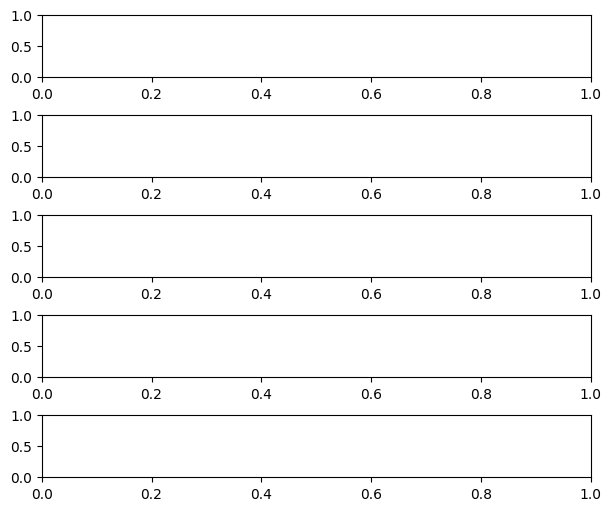

In [15]:
fig, ax = plt.subplots(nrows=5, figsize=(6, 5), layout="constrained")
ax[0].plot(np.array(unet_list_epochs), np.array(unet_train_list_loss), label="train loss UNet")
ax[0].plot(np.array(unet_list_epochs), np.array(unet_val_list_loss), label="val loss UNet")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Cross Entropy Loss")
ax[0].set_title("Train and Val loss Unet")
ax[0].legend()

ax[1].plot(np.array(unet_list_epochs), np.array(attunet_train_list_loss), label="train loss AttUNet")
ax[1].plot(np.array(unet_list_epochs), np.array(attunet_val_list_loss), label="val loss AttUNet")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Cross Entropy Loss")
ax[1].set_title("Train and Val loss Attention Unet")
ax[1].legend()

# ax[2].plot(np.array(unet_list_epochs), np.array(segformer_train_list_loss), label="train loss SegFormer")
# ax[2].plot(np.array(unet_list_epochs), np.array(segformer_val_list_loss), label="val loss SegFormer")
# ax[2].set_xlabel("Epochs")
# ax[2].set_ylabel("Cross Entropy Loss")
# ax[2].set_title("Train and Val loss SegFormer")
# ax[2].legend()

ax[2].plot(np.array(unet_list_epochs), np.array(unet_train_list_loss), label="train loss UNet")
ax[2].plot(np.array(unet_list_epochs), np.array(attunet_train_list_loss), label="train loss AttUNet")
ax[2].plot(np.array(unet_list_epochs), np.array(segformer_train_list_loss), label="train loss SegFormer")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Cross Entropy Loss")
ax[2].set_title("Train loss Models")
ax[2].legend()

ax[3].plot(np.array(unet_list_epochs), np.array(unet_val_list_loss), label="val loss UNet")
ax[3].plot(np.array(unet_list_epochs), np.array(attunet_val_list_loss), label="val loss AttUNet")
ax[3].plot(np.array(unet_list_epochs), np.array(segformer_val_list_loss), label="val loss SegFormer")
ax[3].set_xlabel("Epochs")
ax[3].set_ylabel("Cross Entropy Loss")
ax[3].set_title("Val loss Models")
ax[3].legend()

plt.savefig(fname='models/figure_out_results/train_val_results_models.png', format='png')

# 4. Test Loop

## Evaluate models

In [34]:
def test_step(model, dataloader, loss_fn, epoch, segformer:bool = False):
    model.eval()
    
    test_loss = 0.0
    test_list_loss = []
    batches_list = []
    
    
    # Add a loop through the val batches
    with torch.inference_mode():
        for batch, (img, seg) in enumerate(dataloader):
            batches_list.append(batch)
            # transform mask in true size for SegFormer
            if segformer:
                seg = resize_masks(seg)
            
            #Put data on the target device
            img, seg = img.to(device), seg.to(device)
            
            # Output logits ModelV1
            test_pred = model(img)
            # Encode mask
            seg = encode_segmap(seg.clone())
            # Calculate Loss
            if segformer:
                loss = loss_fn(test_pred.logits, seg.long())
            else:
                loss = loss_fn(test_pred, seg.long())
            test_list_loss.append(loss)
            test_loss += loss
            
            if batch % test_step_vizualise_loss == 0:
                print(f"Batch is {batch} Test Loss: {loss:.4f}")
            
        test_loss /= len(dataloader)
        print(f"Average test loss: {test_loss:.4f}")
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_average_loss": test_loss,
          "model_list_loss": test_list_loss,
           "model_list_batches": batches_list}

In [ ]:
test_dict_unet = test_step(model=UnetModel,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          epoch=epoch)

test_dict_attunet = test_step(model=AttUnetModel,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              epoch=epoch)

test_dict_segformer = test_step(model=SegModel,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              epoch=epoch)

In [ ]:
compare_results = pd.DataFrame([test_dict_unet,
                                test_dict_attunet,
                                test_dict_segformer])
compare_results

NameError: name 'test_dict_unet' is not defined

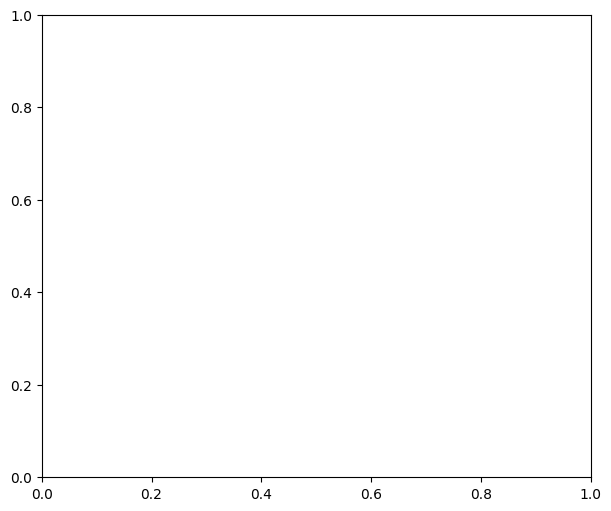

In [16]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")
ax.plot(np.array(test_dict_unet['model_list_batches']), 
        np.array(test_dict_unet['model_list_loss']), 
        label=test_dict_unet['model_name'])

ax.plot(np.array(test_dict_unet['model_list_batches']), 
        np.array(test_dict_attunet['model_list_loss']), 
        label=test_dict_attunet['model_name'])

ax.plot(np.array(test_dict_unet['model_list_batches']), 
        np.array(test_dict_segformer['model_list_loss']), 
        label=test_dict_segformer['model_name'])

ax.set_xlabel("Epochs")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Evaluate models on test dataset")
ax.legend()

plt.savefig(fname='models/figure_out_results/test_results_models.png', format='png')

## Vizualise results

In [68]:
from time import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

UnetModel.eval()
AttUnetModel.eval()
SegModel.eval()

with torch.inference_mode():
    for img, seg in test_dataloader:
        img = img.to(device)
        
        unet_out = UnetModel(img)
        attunet_out = AttUnetModel(img)
        segformer_out = SegModel(img)
        
        break

print(unet_out.shape, attunet_out.shape, segformer_out.logits.shape)

torch.Size([16, 19, 256, 512]) torch.Size([16, 19, 256, 512]) torch.Size([16, 19, 64, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Mask SegFormer')

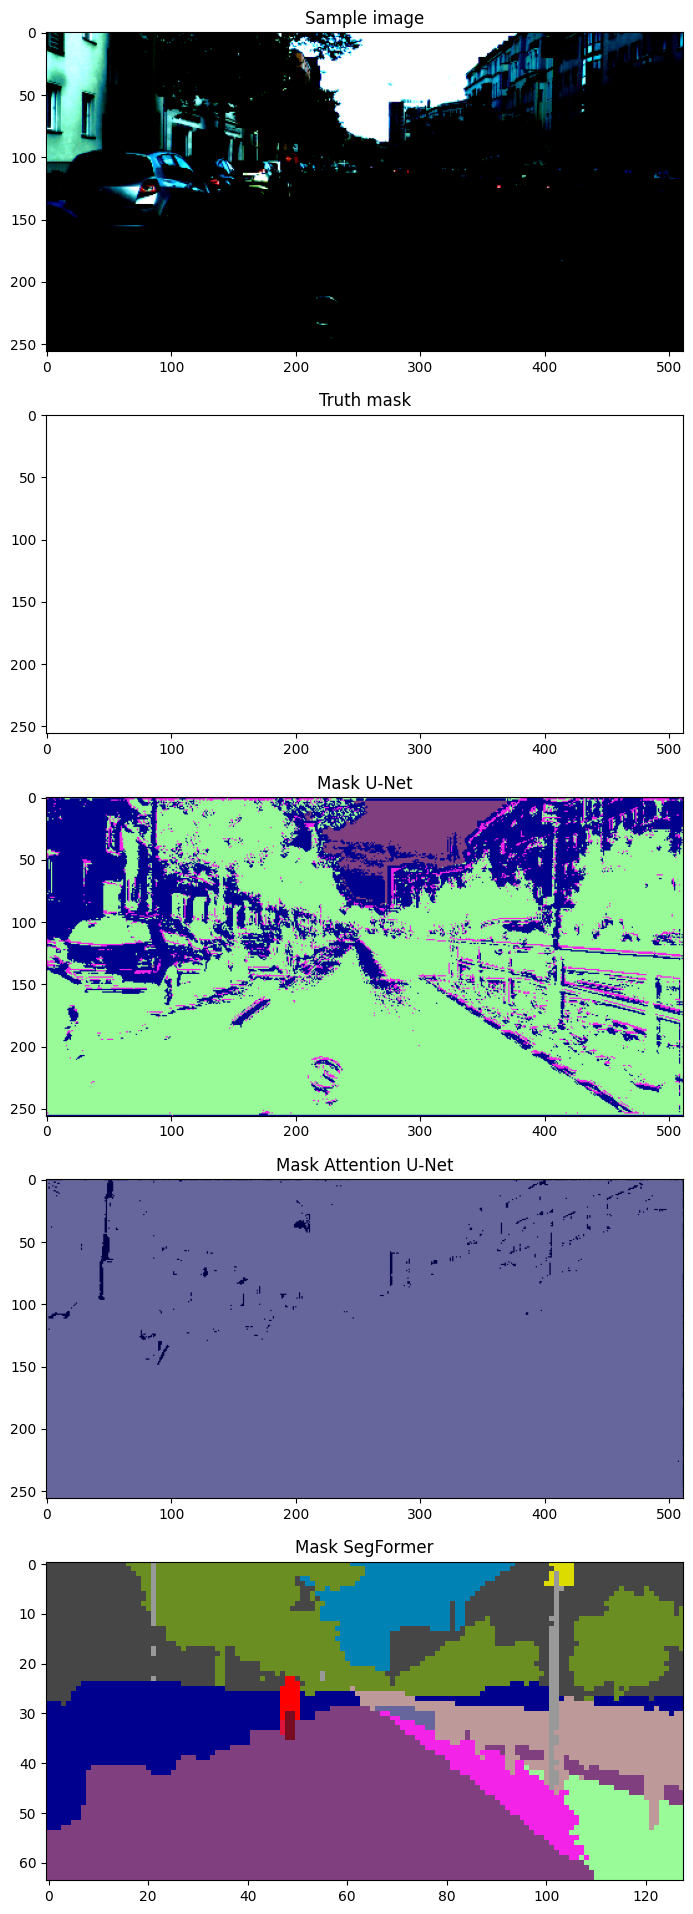

In [69]:
sample = 5

unet_outx = unet_out.detach().cpu()[sample]
attunet_outx = attunet_out.detach().cpu()[sample]
segformer_outx = segformer_out.logits.detach().cpu()[sample]

encoded_mask = encode_segmap(seg[sample].clone())
decoded_mask = decode_segmap(encoded_mask)

decoded_unet_outx = decode_segmap(torch.argmax(unet_outx, dim=0))
decoded_attunet_outx = decode_segmap(torch.argmax(attunet_outx, dim=0))
decoded_segformer_outx = decode_segmap(torch.argmax(segformer_outx, dim=0))



fig, ax = plt.subplots(nrows=5, figsize=(32,24))
ax[0].imshow(np.moveaxis(img[sample].numpy(), 0, 2))
ax[0].set_title('Sample image')
print()
ax[1].imshow(decoded_mask)
ax[1].set_title('Truth mask')

ax[2].imshow(decoded_unet_outx)
ax[2].set_title('Mask U-Net')

ax[3].imshow(decoded_attunet_outx)
ax[3].set_title('Mask Attention U-Net')

ax[4].imshow(decoded_segformer_outx)
ax[4].set_title('Mask SegFormer')


# 5. Save models state dict

In [ ]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models/best_models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME_Unet = "Classic_UnetModel_cityscapes_256x512.pth"
MODEL_NAME_AttUnet = "Classic_AttUnetModel_cityscapes_256x512.pth"
MODEL_NAME_SegFormer = "Classic_SegFormerModel_cityscapes_256x512.pth"

MODEL_SAVE_PATH_Unet = MODEL_PATH / MODEL_NAME_Unet
MODEL_SAVE_PATH_AttUnet = MODEL_PATH / MODEL_NAME_AttUnet
MODEL_SAVE_PATH_SegFormer = MODEL_PATH / MODEL_NAME_SegFormer

# Save the model state dict
print(f"Saving models to: {MODEL_PATH}/")
torch.save(obj=UnetModel.state_dict(),
           f=MODEL_SAVE_PATH_Unet)

torch.save(obj=AttUnetModel.state_dict(),
           f=MODEL_SAVE_PATH_AttUnet)

torch.save(obj=SegModel.state_dict(),
           f=MODEL_SAVE_PATH_SegFormer)

In [ ]:
# Create a new instance
torch.manual_seed(42)
Model_Save_Path = ""

loaded_model = UNetModel(input_channels=3,
                        output_classes=n_classes,
                        up_sample_mode='bilinear',
                        up_sample_align_corner=False,
                        padding=1,
                        stride=1,
                        kernel=3,
                        number_conv_layers=2,
                        )

# Load in the save state_dict()
loaded_model.load_state_dict(torch.load(f=Model_Save_Path))

# Send the model to the target device
loaded_model.to('cpu')
loaded_model